<a href="https://colab.research.google.com/github/tohocho/SistemasDistribuidosll/blob/master/Clase_SDUll_21_05_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problemas ridiculamente paralelizables

Se define como la trivialidad de dividir los datos en pedazos y aplicarle las mismas condiciones a cada uno de esos pedazos

In [0]:
from math import sqrt
from dask import delayed
import os
from time import sleep
import pandas as pd

In [0]:
def f(z):
  return sqrt(z+4)

def g(y):
  return y-3

def h(x):
  return x**2

In [4]:
x=4
y = h(x)
z = g(y)
w = f(z)
w
  

4.123105625617661

w = f(g(h(x)))
w

In [0]:
data = [1, 2, 3, 4, 5]

In [7]:
for x in data:
  print(f(g(h(x))))

1.4142135623730951
2.23606797749979
3.1622776601683795
4.123105625617661
5.0990195135927845


In [9]:
%%time
[f(g(h(x))) for x in data] #Comprensión de listas

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 16.7 µs


[1.4142135623730951,
 2.23606797749979,
 3.1622776601683795,
 4.123105625617661,
 5.0990195135927845]

La lista anterior se genera secuencialmente, ¿cómo la podemos generar en forma paralela?

In [15]:
x=4
y = delayed(h)(x)
z = delayed(g)(y)
w = delayed(f)(z)
print(w)

Delayed('f-0bf3be70-e62c-4753-8b48-7569e9ceb710')


In [19]:
type(w)

dask.delayed.Delayed

In [20]:
w.compute()

4.123105625617661

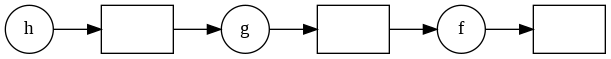

In [27]:
w.visualize(rankdir='LR')

In [28]:
h(x)

16

In [0]:
def f(x):
  return sqrt(x+4)

f = delayed(f)

In [30]:
@delayed
def f(x):
  return sqrt(x+4)

print(type(f))

<class 'dask.delayed.DelayedLeaf'>


Ejemplo usando decoradores

In [0]:
@delayed
def incrementa(x):
  return x+1

@delayed
def dobla(x):
  return 2*x

@delayed
def suma (x,y):
  return x+y

In [6]:
data

NameError: ignored

In [0]:
output = []
for x in data:
  a = incrementa(x)
  b = dobla(x)
  c = suma (a,b)
  
  output.append(c)

In [35]:
output()

[Delayed('suma-771503ac-46e3-4276-9357-e02625f0dad8'),
 Delayed('suma-ff23157e-0471-46df-9706-cda82d375ee8'),
 Delayed('suma-2d55d5e8-c000-4ee1-89c3-920d20146677'),
 Delayed('suma-c4b5a7f9-ac12-4fe4-b779-a09a2c340607'),
 Delayed('suma-9906382c-468e-4eaf-8e86-3dcf3f4bfa23')]

In [38]:
total = sum(output)
type(total)

dask.delayed.Delayed

In [44]:
[res.compute() for res in output]

[4, 7, 10, 13, 16]

In [0]:
total.visualize(rankdir='LR')

In [42]:
total.compute()

50

In [0]:
#@delayed
def incrementa(x):
  return x+1

#@delayed
def dobla(x):
  return 2*x

#@delayed
def suma (x,y):
  return x+y

In [48]:
type(suma)

function

In [54]:
%%time
a = incrementa (1)
b = dobla(2)
c = suma(a,b)

CPU times: user 973 µs, sys: 0 ns, total: 973 µs
Wall time: 3.67 ms


In [55]:
%%time
c.compute()

CPU times: user 3.31 ms, sys: 58 µs, total: 3.37 ms
Wall time: 3 ms


6

In [0]:
def inc(x):
  sleep(1)
  return x+1

In [10]:
%%time
res =[]
for x in data:
  y = inc(x)
  res.append(y)
  
total = sum(res)

CPU times: user 1.16 ms, sys: 1.06 ms, total: 2.22 ms
Wall time: 5 s


In [13]:
#Paralelo
%%time
res =[]
for x in data:
  y = delayed(inc)(x)
  res.append(y)
  
total = delayed(sum)(res)
total.compute()

CPU times: user 8.58 ms, sys: 4.84 ms, total: 13.4 ms
Wall time: 3.01 s


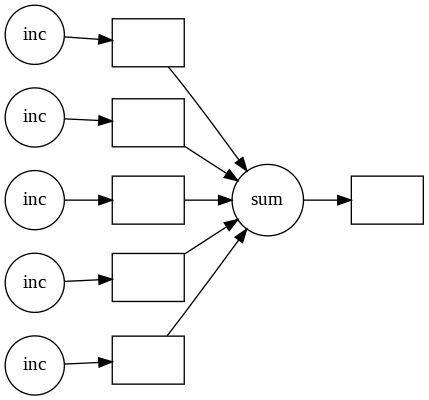

In [15]:
total.visualize(rankdir='LR')

In [0]:
plantilla = 'yellow_tripdata_2018-{:02d}.csv'
plantillaURL='wget https://s3.amazonaws.com/nyc-tlc/trip+data/'+plantilla
urls = (plantillaURL.format(k) for k in range (1,13)) #generador
for url in urls:
  os.system(url)

In [0]:
@delayed
def cuenta_viajes_tardados(df):
  df['duracion'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.seconds
  es_viaje_tardado = df.duracion > 1200
  result_dict = {'n_long': [sum(es_viaje_tardado)], 'n_total': [len(df)]}
  return pd.DataFrame(result_dict)

@delayed
def abre_archivo(nombre):
  return pd.read_csv(nombre, parse_dates=[1,2])

In [0]:
archivos = [plantilla.format(k) for k in range (1,12)]

In [0]:
total = [cuenta_viajes_tardados(abre_archivo(archivo)) for archivo in archivos]

In [0]:
semi_anual = sum(total)

In [0]:
semi_anual.visualize(rankdir='LR')

In [44]:
%%time
semi_anual.compute()

CPU times: user 4min 37s, sys: 12.2 s, total: 4min 49s
Wall time: 4min 14s


,n_long,n_total
0,13309676,62378083


#Arreglos o matrices usando dask

In [0]:
import numpy as np
import dask.array as da

In [0]:
a = np.random.rand(10000)

In [49]:
print (a.shape, a.dtype, a.nbytes)

(10000,) float64 80000


In [57]:
a.sum()

4973.770026648407

In [58]:
a.mean()

0.4973770026648407

In [0]:
a_dask = da.from_array(a,chunks=len(a)//3)

In [85]:
type(a_dask)

dask.array.core.Array

In [96]:
a_dask.chunks

((3333, 3333, 3333, 1),)

In [0]:
n_chunks = 8
chunk_size = len(a)// n_chunks
result = 0

In [0]:
for k in range (n_chunks):
  offset = k*chunk_size
  a_chunk = a[offset:offset+chunk_size]
  result +=a_chunk.sum()

In [99]:
print(result)

4973.770026648408


In [100]:
a.sum()

4973.770026648407

In [0]:
result_dask = a_dask.sum()

In [102]:
result_dask

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>

In [103]:
result_dask.compute()

4973.770026648407

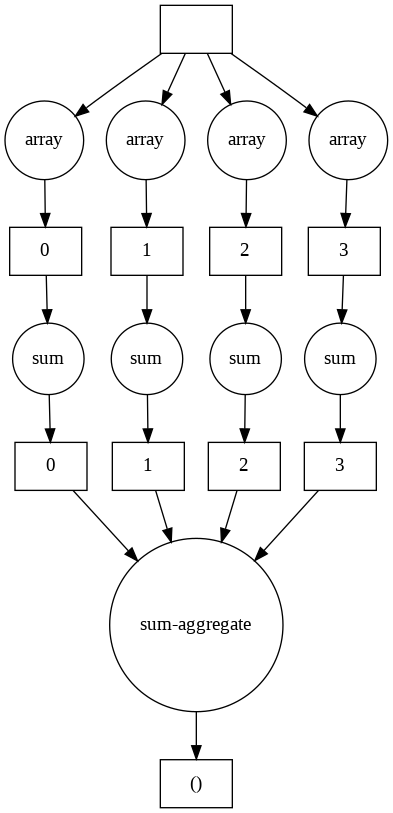

In [104]:
result_dask.visualize(rankdir='lr')